Импортируем данные из датасета о вложениях в рекламу и количестве проданной продукции

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Advertising_Data.csv to Advertising_Data.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics as st
import math
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import SCORERS

In [ ]:
df = pd.read_csv(open('Advertising_Data.csv','rb'))
df

,TV,Billboards,Google_Ads,Social_Media,Influencer_Marketing,Affiliate_Marketing,Product_Sold
0,281.42,538.80,123.94,349.30,242.77,910.10,7164.0
1,702.97,296.53,558.13,180.55,781.06,132.43,5055.0
2,313.14,295.94,642.96,505.71,438.91,464.23,6154.0
3,898.52,61.27,548.73,240.93,278.96,432.27,5480.0
4,766.52,550.72,651.91,666.33,396.33,841.93,9669.0
...,...,...,...,...,...,...,...
295,770.05,501.36,694.60,172.26,572.26,410.56,6851.0
296,512.38,250.83,373.78,366.95,987.14,509.03,6477.0
297,998.10,858.75,781.06,60.61,174.63,213.53,6949.0
298,322.35,681.22,640.29,343.65,534.22,648.71,7737.0


ТВ: Расходы на рекламу на телевидении.

Рекламные щиты: расходы на рекламу, связанные с рекламными щитами.

Google_Ads: расходы на рекламу, понесенные в Google Ads.

Social_Media: расходы на рекламу в различных социальных сетях.

Influencer_Marketing: Затраты, связанные с влиятельным маркетингом.

Affiliate_Marketing: расходы на партнерский маркетинг.

Product_Sold: количество проданных единиц, соответствующее расходам на рекламу на


____На данном этапе проведем чистку данных от выбросов,____
а для начала рассмотрим корреляционную матрицу признаков

In [ ]:
df.corr()

,TV,Billboards,Google_Ads,Social_Media,Influencer_Marketing,Affiliate_Marketing,Product_Sold
TV,1.000000,-0.028851,0.025265,-0.038993,0.009970,0.087524,0.374228
Billboards,-0.028851,1.000000,0.052991,0.048722,-0.005815,-0.041060,0.480593
Google_Ads,0.025265,0.052991,1.000000,0.040265,-0.059243,-0.131834,0.203678
Social_Media,-0.038993,0.048722,0.040265,1.000000,-0.042679,-0.019522,0.401088
Influencer_Marketing,0.009970,-0.005815,-0.059243,-0.042679,1.000000,-0.047093,0.140844
Affiliate_Marketing,0.087524,-0.041060,-0.131834,-0.019522,-0.047093,1.000000,0.611603
Product_Sold,0.374228,0.480593,0.203678,0.401088,0.140844,0.611603,1.000000


Нас интересуют значения для целевой переменной Product_Sold,
и как мы заметили данная переменная не имеет выраженной корреляции с каким-либо признаком

In [ ]:
df.corr()['Product_Sold'].sort_values()


Influencer_Marketing    0.140844
Google_Ads              0.203678
TV                      0.374228
Social_Media            0.401088
Billboards              0.480593
Affiliate_Marketing     0.611603
Product_Sold            1.000000
Name: Product_Sold, dtype: float64

Построим визуализацию для данных

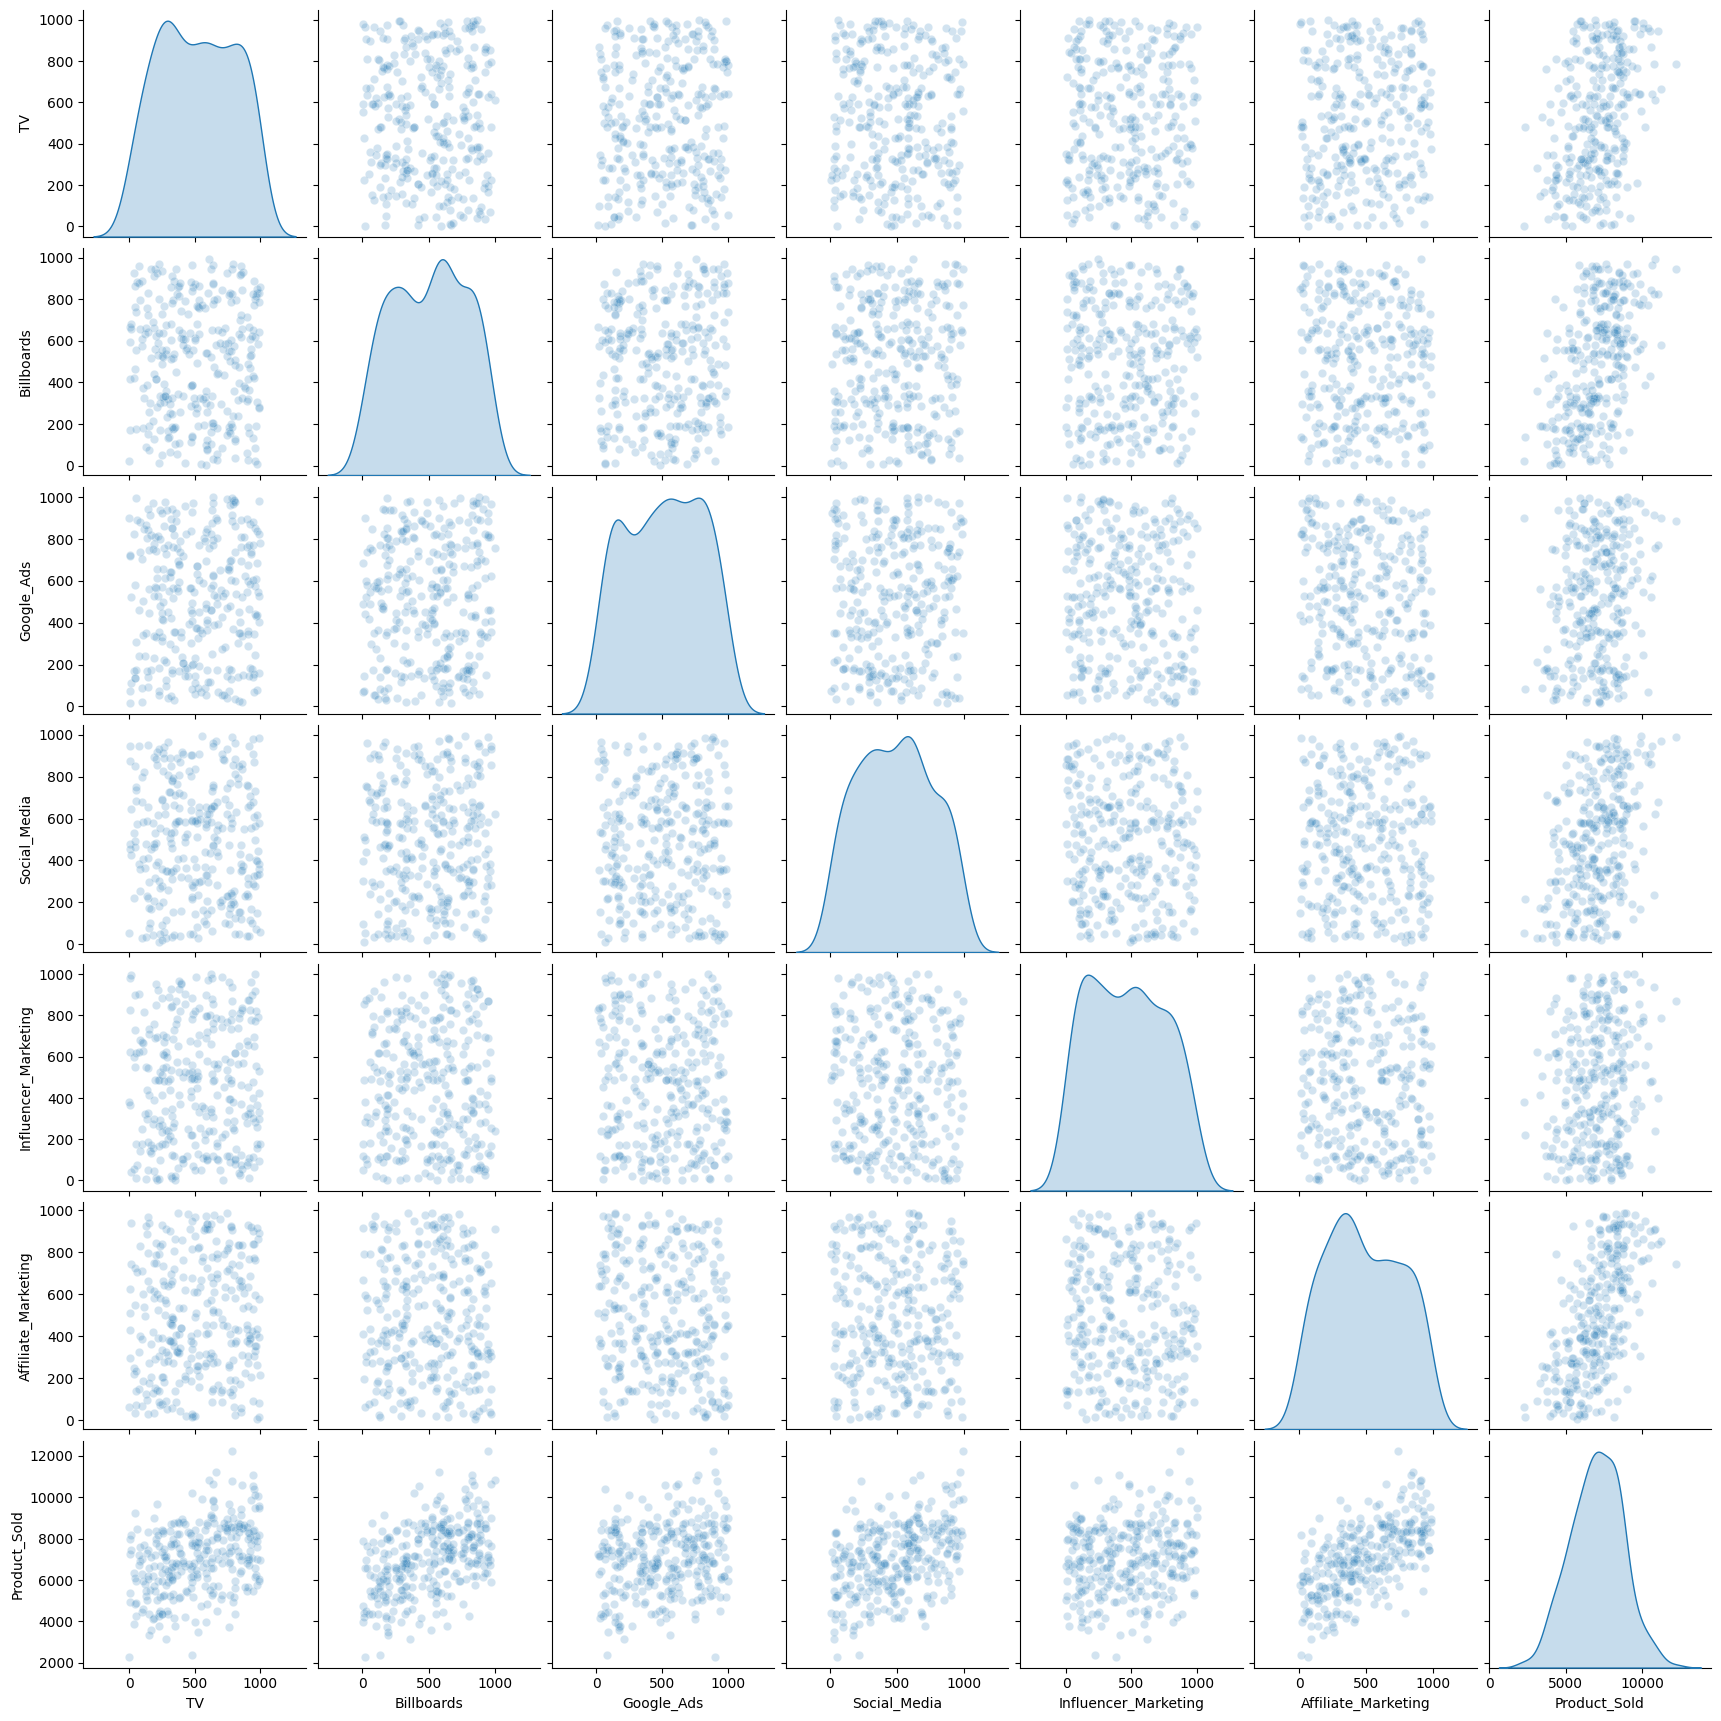

In [ ]:
sns.pairplot(df, diag_kind="kde", plot_kws={"alpha":0.2});

Если обратить внимание на последнюю строку в таблице графиков, можно увидеть в каждой клетке выбросы, их немного, но они имеются

1) сначала воспользуемся интерквартильным размахом

In [ ]:
for i in range(len(df.columns)):
  Q1 = df.iloc[:,i].quantile(0.25)
  Q3 = df.iloc[:,i].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  filtered_data = df[(df.iloc[:,i] > lower_bound) & (df.iloc[:,i] < upper_bound)]
print(filtered_data)
df = filtered_data

         TV  Billboards  Google_Ads  Social_Media  Influencer_Marketing  \
0    281.42      538.80      123.94        349.30                242.77   
1    702.97      296.53      558.13        180.55                781.06   
2    313.14      295.94      642.96        505.71                438.91   
3    898.52       61.27      548.73        240.93                278.96   
4    766.52      550.72      651.91        666.33                396.33   
..      ...         ...         ...           ...                   ...   
295  770.05      501.36      694.60        172.26                572.26   
296  512.38      250.83      373.78        366.95                987.14   
297  998.10      858.75      781.06         60.61                174.63   
298  322.35      681.22      640.29        343.65                534.22   
299  476.45      884.77      301.79        802.30                434.82   

     Affiliate_Marketing  Product_Sold  
0                 910.10        7164.0  
1                

2) воспользуемся правилом трёх сигм

In [ ]:
for i in range(len(df.columns)):
  mean = df.iloc[:,i].mean()
  std = df.iloc[:,i].std()

  lower_bound = mean - 3 * std
  upper_bound = mean + 3 * std

  filtered_data = df[(df.iloc[:,i] > lower_bound) & (df.iloc[:,i] < upper_bound)]
print(filtered_data)
df = filtered_data

         TV  Billboards  Google_Ads  Social_Media  Influencer_Marketing  \
0    281.42      538.80      123.94        349.30                242.77   
1    702.97      296.53      558.13        180.55                781.06   
2    313.14      295.94      642.96        505.71                438.91   
3    898.52       61.27      548.73        240.93                278.96   
4    766.52      550.72      651.91        666.33                396.33   
..      ...         ...         ...           ...                   ...   
295  770.05      501.36      694.60        172.26                572.26   
296  512.38      250.83      373.78        366.95                987.14   
297  998.10      858.75      781.06         60.61                174.63   
298  322.35      681.22      640.29        343.65                534.22   
299  476.45      884.77      301.79        802.30                434.82   

     Affiliate_Marketing  Product_Sold  
0                 910.10        7164.0  
1                

3) воспользуемся критерием Шовене

In [ ]:
def shovene(data):
    df=data.tolist()
    iteration_counter = 0
    pp=[ ] #запишем выбросы  переменную
    while True and len(df) > 1:
        iteration_counter += 1
        stop_iter = True
        p_mean = st.mean(df)
        p_stdev = st.stdev(df)
        print("Итерация:", iteration_counter)# распечатывается номер итерации
        for p in list(df):
            if p_stdev > 0 and\
                math.erfc (math.fabs (p-p_mean)/p_stdev)<1/(2*len(df)):
                print("Обнаружена аномалия:", p)# распечатывается факт аномального выброса
                pp.append(p)
                df.remove(p)
                stop_iter = False
        if stop_iter:
            break
    d_float=np.array(pp, dtype=np.float32)
    return round((len(d_float)/len(data)*100),2), d_float

for i in range(len(df.columns)):
  print(shovene(df.iloc[:,i]))


Итерация: 1
(0.0, array([], dtype=float32))
Итерация: 1
(0.0, array([], dtype=float32))
Итерация: 1
(0.0, array([], dtype=float32))
Итерация: 1
(0.0, array([], dtype=float32))
Итерация: 1
(0.0, array([], dtype=float32))
Итерация: 1
(0.0, array([], dtype=float32))
Итерация: 1
Обнаружена аномалия: 11210.0
Обнаружена аномалия: 10763.0
Обнаружена аномалия: 3141.0
Обнаружена аномалия: 3335.0
Обнаружена аномалия: 10841.0
Обнаружена аномалия: 11062.0
Итерация: 2
Обнаружена аномалия: 10543.0
Обнаружена аномалия: 3473.0
Обнаружена аномалия: 10585.0
Обнаружена аномалия: 10655.0
Итерация: 3
Обнаружена аномалия: 3600.0
Обнаружена аномалия: 10387.0
Итерация: 4
(4.04, array([11210., 10763.,  3141.,  3335., 10841., 11062., 10543.,  3473.,
       10585., 10655.,  3600., 10387.], dtype=float32))


In [ ]:
outliers = [11210., 10763.,  3141.,  3335., 10841., 11062., 10543.,  3473.,10585., 10655.,  3600., 10387.]
df = df[df["Product_Sold"].apply(lambda el: el not in outliers)]
len(df)

285

Таким образом получаем после обработки данных 285 строк, вместо изначальных 300,
и это хорошо, так как процент выбросов небольшой

Далее можно перейти к построению модели,
Начнем с линейной модели

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


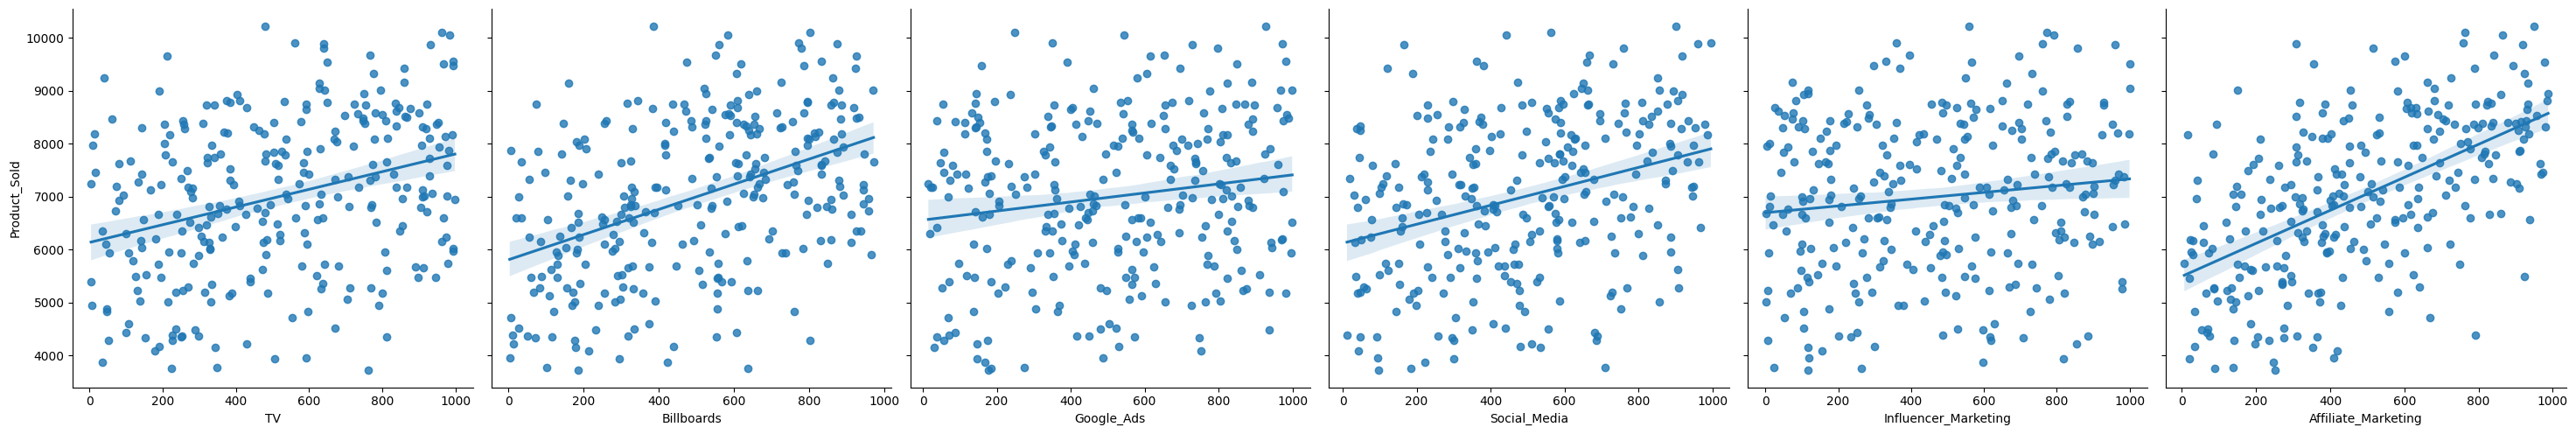

In [ ]:
sns.pairplot(df, y_vars='Product_Sold', x_vars=['TV',	'Billboards',	'Google_Ads',	'Social_Media',	'Influencer_Marketing',	'Affiliate_Marketing'], size=5, kind='reg', diag_kind=None);

На парных графиках можно обратить внимание, что линейная взаимосвязь присутствует, на некоторых причем ярко выражено

Стоит обратить внимание на график 3 и график 5, а также обратить на значение коэффициента корреляции,
линейная взаимосвязь слабая, данные факторные переменные оказывают слабое влияние на результирующую

In [ ]:
model = smf.ols('Product_Sold ~ Google_Ads', data=df)
res = model.fit()
print(res.summary())

model = smf.ols('Product_Sold ~ Influencer_Marketing', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Product_Sold   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     7.650
Date:                Wed, 20 Dec 2023   Prob (F-statistic):            0.00605
Time:                        10:54:53   Log-Likelihood:                -2482.6
No. Observations:                 285   AIC:                             4969.
Df Residuals:                     283   BIC:                             4976.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6557.2612    180.121     36.405      0.0

И так проведя регрессионный анализ, мы видим по значениям R2 и значениям F и t статистики, что коэффициенты парных регрессий статистически незначимы, также незначимы модели в целом.
Можно сказать, что данные факторные переменные не несут пользы для модели по отдельности.

In [ ]:
X = df.drop(['Product_Sold'],axis=1) #,'Influencer_Marketing','Google_Ads'
y = df['Product_Sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


На данном этапе заполняем тренировочную и тестовую выбурку

In [ ]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
test_lin_predictions = linear_regression_model.predict(X_test) # здесь мы предсказали значения модели по тестовой выборке

In [ ]:
MAE = mean_absolute_error(y_test, test_lin_predictions)
MSE = mean_squared_error(y_test, test_lin_predictions)
R2 = r2_score(y_test, test_lin_predictions)
RMSE = np.sqrt(MSE)
print(f"MAE = {MAE}, MSE = {MSE}, RMSE = {RMSE}, R2 = {R2}")

MAE = 7.049075939117201, MSE = 82.34938916735551, RMSE = 9.074656421449548, R2 = 0.9999664972607311


Среднее значение результирующей переменной Product_Sold это значение 6993.063157894737


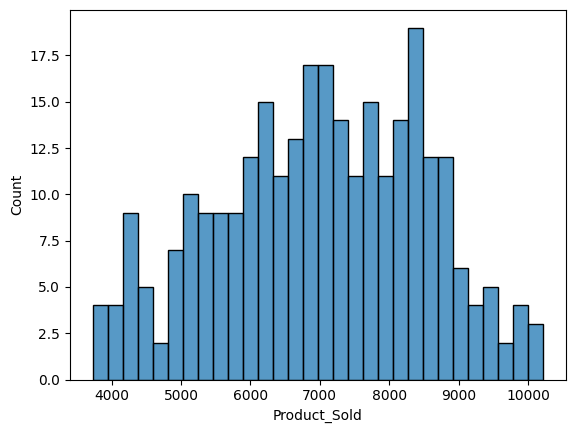

In [ ]:
Product_Sold_mean =  df["Product_Sold"].mean()
print(f"Среднее значение результирующей переменной Product_Sold это значение {Product_Sold_mean}")
sns.histplot(data=df,x="Product_Sold",bins=30);

Посчитав среднее значение и увидев диапазон примерно от 3000 до 10000 значений результирующей переменной,
можно сделать вывод по нашим метрикам, что если сравнить среднее значение 6993
и значение наших метрик 7 и 9, можем сказать, что ошибаться на данных, которые наша модель еще не видела будем в менее чем 1 % случаях

In [ ]:
final_lin_model = LinearRegression()
final_lin_model.fit(X,y)

LinearRegression()

In [ ]:
final_lin_model.coef_

array([2.00084939, 2.99768703, 1.49948122, 2.49977745, 1.19954013,
       3.99819607])

In [ ]:
test_lin_predictions = linear_regression_model.predict(X)

MAE = mean_absolute_error(y, test_lin_predictions)
MSE = mean_squared_error(y, test_lin_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y, test_lin_predictions)
print(f"MAE = {MAE}, MSE = {MSE}, RMSE = {RMSE}  R2 = {R2}")

MAE = 8.211024055031485, MSE = 105.2204232204375, RMSE = 10.257700679023419  R2 = 0.9999524744361449


На данном этапе осуществляется обучение модели на всех данных, так как обученная модель дала хорошие результаты, а на всех данных получим точные значения

**Вывод:** каждый из факторных признаков в совокупности значимо влияет на значение результирующей переменной, если обратить внимание на коэффициенты регрессии, то с увеличением денежных вложений на одну единицу в каждом рекламном направлении количество проданных единиц заметно вырастает.

In [ ]:
model = smf.ols('Product_Sold ~ TV + Billboards	+ Social_Media + Affiliate_Marketing + Influencer_Marketing + Google_Ads ', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Product_Sold   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.848e+05
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:37:40   Log-Likelihood:                -1066.4
No. Observations:                 285   AIC:                             2147.
Df Residuals:                     278   BIC:                             2172.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.2491 

Проверяя гипотезы о значимости коэффициентов и модели в целом получаем значение статистик, после чего можно сказать, что модель значима и коэффициенты значимы и отличны от нуля

**На данном этапе нужно попробовать пострить полиномиальную модель и оценить лучше она или хуже линейной**

In [ ]:
polynomial_convert = PolynomialFeatures(degree=2, include_bias=False)
poly_features = polynomial_convert.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)

In [ ]:
pol_model = LinearRegression()
pol_model.fit(X_train,y_train)

LinearRegression()

In [ ]:
test_pol_predictions = pol_model.predict(X_test)
pol_model.coef_

array([ 1.97459561e+00,  2.97586124e+00,  1.47324054e+00,  2.51324372e+00,
        1.20313184e+00,  3.99134784e+00,  1.35092217e-05, -9.70028188e-07,
        7.42663325e-06,  6.75353289e-06,  7.97201145e-07,  8.48746042e-06,
        7.52340867e-06,  7.72058565e-06, -7.47355305e-06,  1.92188767e-05,
        6.84182254e-06,  3.10910961e-06,  8.76730370e-06,  1.99029642e-05,
        5.56442772e-07, -1.02189755e-05, -9.70816628e-06, -6.09089967e-06,
       -1.63762055e-05, -6.04435921e-06,  3.76996158e-06])

Нужно обратить внимание, что первые шесть коэффициентов отличны от нуля, а остальные практически равны нулю

In [ ]:
MAE = mean_absolute_error(y_test, test_pol_predictions)
MSE = mean_squared_error(y_test, test_pol_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, test_pol_predictions)
print(f"MAE = {MAE}, MSE = {MSE}, RMSE = {RMSE}, R2 = {R2}")

MAE = 7.49621882510302, MSE = 94.31628290903839, RMSE = 9.711657062985616, R2 = 0.9999616286912743


**Вывод:** если сравнить значения метрик с линейной моделью, то полиномиальная немного уступает.


**На данном этапе построим Гребневую регрессию**

In [ ]:
ridge_cv_model = RidgeCV(alphas=(10.0,100.0), scoring='neg_mean_squared_error')

In [ ]:
ridge_cv_model.fit(X_train,y_train)

RidgeCV(alphas=(10.0, 100.0), scoring='neg_mean_squared_error')

In [ ]:
ridge_cv_model.alpha_

10.0

Наилучшее значение параметра альфа 10

In [ ]:
#SCORERS.keys()

In [ ]:
test_ridg_predictions = ridge_cv_model.predict(X_test)

In [ ]:
MAE = mean_absolute_error(y_test, test_ridg_predictions)
MSE = mean_squared_error(y_test, test_ridg_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, test_ridg_predictions)
print(f"MAE = {MAE}, MSE = {MSE}, RMSE = {RMSE}, R2 = {R2}")

MAE = 8.510448776892792, MSE = 116.63984113851474, RMSE = 10.799992645299104, R2 = 0.9999525466524336


In [ ]:
ridge_cv_model.coef_

array([ 1.97446073e+00,  2.97565218e+00,  1.47315474e+00,  2.51307710e+00,
        1.20304587e+00,  3.99109201e+00,  1.16855954e-05, -1.63954974e-06,
        5.15377178e-06,  7.22203549e-06,  2.61672540e-06,  7.21668766e-06,
        8.03030707e-06,  6.61076774e-06, -5.90566196e-06,  2.17369816e-05,
        6.86253770e-06,  1.11119880e-06,  8.84039036e-06,  2.14939937e-05,
       -1.11403278e-06, -7.81606650e-06, -6.24239328e-06, -5.29881072e-06,
       -1.20303775e-05, -4.46591730e-06,  2.29319448e-06])

Можно сказать, что данная модель тоже хорошо описывает наши данные, но все-таки немного уступает линейной модели.

**Общий вывод:** 1) при увеличении вложений в рекламу на TV на 100 денежных единиц количество проданной продукции в среднем будет увеличиваться на 200 единиц.

2)при увеличении вложений в Billboards на 100 денежных единиц количество проданной продукции в среднем будет увеличиваться на 300 единиц.

3)при увеличении вложений в рекламу в Social_Media на 100 денежных единиц количество проданной продукции в среднем будет увеличиваться на 250 единиц.

4)при увеличении вложений в рекламу в Affiliate_Marketing на 100 денежных единиц количество проданной продукции в среднем будет увеличиваться на 400 единиц.

5)при увеличении вложений в рекламу в Influencer_Marketing на 100 денежных единиц количество проданной продукции в среднем будет увеличиваться на 195 единиц.

6)при увеличении вложений в рекламу Google_Ads на 100 денежных единиц количество проданной продукции в среднем будет увеличиваться на 150 единиц.
